# Hi-Res vs. Coarse Benguela
A quick movie comparison of the high-resolution hindcast Benguela Current versus the low-resolution CESM1-LENS Benguela Current. 

In [1]:
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
plt.style.use('ocn-clim')
%matplotlib inline
import cmocean.cm as cm

from mpl_toolkits.basemap import Basemap

In [3]:
lat1 = -30
lat2 = -15
lon1 = 0
lon2 = 25

# Functions

In [4]:
def find_indices(latGrid, lonGrid, latPoint, lonPoint):
    dx = lonGrid - lonPoint
    dy = latGrid - latPoint
    reducedGrid = abs(dx) + abs(dy)
    min_ix = np.nanargmin(reducedGrid)
    i, j = np.unravel_index(min_ix, reducedGrid.shape)
    return i, j

# If the data has already been processed, just load the netcdf files here and skip the next two chunks

In [5]:
hires_dir = '/glade/scratch/rbrady/HI_RES/2003_50m_WVEL_Benguela.nc'
ds_hi = xr.open_dataset(hires_dir)

In [72]:
lores_dir = '/glade/scratch/rbrady/HI_RES/2003_50m_WVEL_Benguela_COARSE3.nc'
ds_lo = xr.open_dataset(lores_dir)


# Extract Benguela for Low Resolution
So for the current iteration, I'm just going to draw the whole ensemble and slice into just 2003 to match the high resolution.

In [64]:
inDir ='/glade/p/work/rbrady/EBUS_BGC_Variability/WVEL/BenCS/'
fileName = 'WVEL.*.BenCS.192001-201512.nc'
ds_lens = xr.open_mfdataset(inDir + fileName, concat_dim='ensemble')

In [65]:
lat = ds_lens['TLAT'][0].values
lon = ds_lens['TLONG'][0].values
a, c = find_indices(lat, lon, lat1, lon1)
b, d = find_indices(lat, lon, lat2, lon2)

In [66]:
ds_lens = ds_lens['WVEL'].sel(nlat=slice(a, b), nlon=slice(c, d), time=slice('2003-01', '2003-12'))

In [67]:
# ensemble mean drops latitude and longitude for some reason
lat_recover = ds_lens['TLAT'][0]
lon_recover = ds_lens['TLONG'][0]

In [68]:
ds_lens = ds_lens.mean(dim='ensemble')

In [69]:
ds_lens['TLAT'] = lat_recover
ds_lens['TLONG'] = lon_recover

In [70]:
ds_lens = ds_lens * (60 * 60 * 24) * (1/100) # Convert to m/day

In [71]:
ds_lens.to_netcdf('/glade/scratch/rbrady/HI_RES/2003_50m_WVEL_Benguela_COARSE3.nc')

/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Extract Benguela for High Resolution

In [ ]:
fileDir = '/glade/p/cmia0001/TL319_t12/archive/g.e20.G.TL319_t12.GIAF.005/ocn/hist/'
fileName = 'g.e20.G.TL319_t12.GIAF.005.pop.h.2003-*.nc'
# After getting a snapshot going, will glob in all of 2003 for a loop.

In [ ]:
ds_hi = xr.open_mfdataset(fileDir + fileName, decode_times=False)

In [ ]:
ds_hi = ds_hi['WVEL']
ds_hi = ds_hi.squeeze()
ds_hi = ds_hi[:, 5] # 50m depth

In [ ]:
timeRef = pd.date_range('2003-01', '2004-01', freq='M')
ds_hi['time'] = timeRef

In [ ]:
lat = ds_hi['TLAT'].values
lon = ds_hi['TLONG'].values

In [ ]:
a, c = find_indices(lat, lon, lat1, lon1)
b, d = find_indices(lat, lon, lat2, lon2)

In [ ]:
ds_hi = ds_hi.isel(nlat=slice(a,b), nlon=slice(c, d))

In [ ]:
ds_hi = ds_hi * (60 * 60 * 24) * (1/100) # Convert to m/day

In [ ]:
ds_hi.to_netcdf('/glade/scratch/rbrady/HI_RES/2003_50m_WVEL_Benguela.nc')

# Visualize

In [6]:
def setup_map(ax):
    m = Basemap(projection='eqdc',
               lat_0=-20, lon_0=10,
               llcrnrlat=-40, llcrnrlon=0,
               urcrnrlat=-10, urcrnrlon=25,
               resolution='c', fix_aspect=False)
    m.fillcontinents(color='k')
    return m

In [73]:
# Set up data
lon_hi = ds_hi['TLONG'].values
lat_hi = ds_hi['TLAT'].values
data_hi = ds_hi['WVEL'].values
data_hi = np.ma.array(data_hi, mask=np.isnan(data_hi))

# Coarse res
lon_lo = ds_lo['TLONG'].values
lat_lo = ds_lo['TLAT'].values
data_lo = ds_lo['WVEL'].values
data_lo = np.ma.array(data_lo, mask=np.isnan(data_lo))

In [74]:
months = ['January', 'February', 'March', 'April',
          'May', 'June', 'July', 'August', 'September',
          'October', 'November', 'December']
nums = ['001','002','003','004','005','006',
        '007','008','009','010','011','012']

# Set up stationary figure

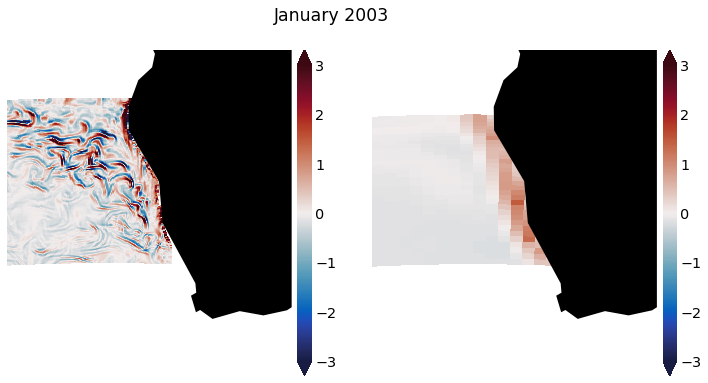

In [79]:
fig = plt.figure(figsize=(12,6))

plt.suptitle('January 2003', fontsize='xx-large')

# HIGH RES
ax = plt.subplot(121)
m = setup_map(ax)
m.pcolor(lon_hi, lat_hi, data_hi[8], vmin=-3, vmax=3, latlon=True, cmap=cm.balance)
m.colorbar(extend='both')

# LOW RES
ax = plt.subplot(122)
m = setup_map(ax)
m.pcolor(lon_lo, lat_lo, data_lo[8], vmin=-3, vmax=3, latlon=True, cmap=cm.balance)
m.colorbar(extend='both')

# Loop for Animation

In [80]:
for idx in np.arange(0, 12, 1):
    fig = plt.figure(figsize=(12,6))
    plt.suptitle(months[idx] + ' 2003', fontsize='xx-large')
    # HIGH RES
    ax = plt.subplot(121)
    m = setup_map(ax)
    m.pcolor(lon_hi, lat_hi, data_hi[idx], vmin=-3, vmax=3, latlon=True, cmap=cm.balance)
    m.colorbar(extend='both')
    # LOW RES
    ax = plt.subplot(122)
    m = setup_map(ax)
    m.pcolor(lon_lo, lat_lo, data_lo[idx], vmin=-3, vmax=3, latlon=True, cmap=cm.balance)
    m.colorbar(extend='both')
    plt.savefig('image' + nums[idx] + '.png', transparent=False,
                bbox_inches='tight', pad_inches=1, dpi=300)
    plt.clf()